# Reconociendo Digitos con Aprendizaje Supervisado
Gabriel Suarez

## Importando librerias

In [798]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

## Cargando datos

In [770]:
df = pd.read_csv('../data/train.csv')

In [771]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [772]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [773]:
df.drop(['id'], axis=1, inplace=True)
df.drop(['Unnamed: 32'], axis=1, inplace=True)

In [774]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

In [775]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Explorando datos

In [776]:
df = df.iloc[:, 0:11]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 49.0 KB


In [777]:
df_corr = df.copy()
df_corr.drop(['diagnosis'], axis=1, inplace=True)

<Axes: >

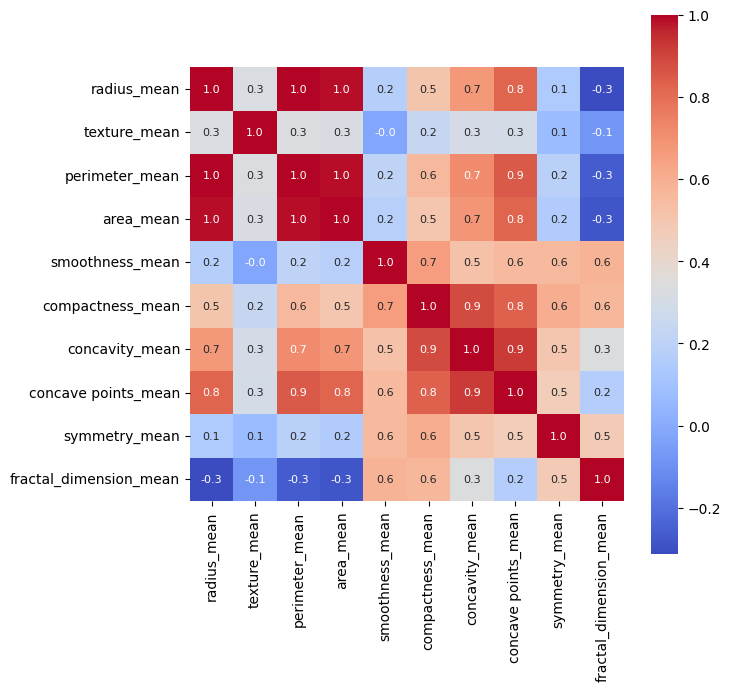

In [778]:
corr = df_corr.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.1f',annot_kws={'size': 8},
           xticklabels= df_corr.columns, yticklabels= df_corr.columns,
           cmap= 'coolwarm')

In [779]:
df.drop(['concavity_mean', 'radius_mean', 'perimeter_mean', 'concave points_mean'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   texture_mean            569 non-null    float64
 2   area_mean               569 non-null    float64
 3   smoothness_mean         569 non-null    float64
 4   compactness_mean        569 non-null    float64
 5   symmetry_mean           569 non-null    float64
 6   fractal_dimension_mean  569 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.2 KB


In [780]:

X_train, X_test, y_train, y_test = train_test_split(df.drop(["diagnosis"], axis=1), df["diagnosis"], test_size=0.3, random_state=42)


In [781]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

C:\Users\Gabriel Suarez\AppData\Local\Temp\ipykernel_7980\1226062771.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.cm.get_cmap("viridis", 2))


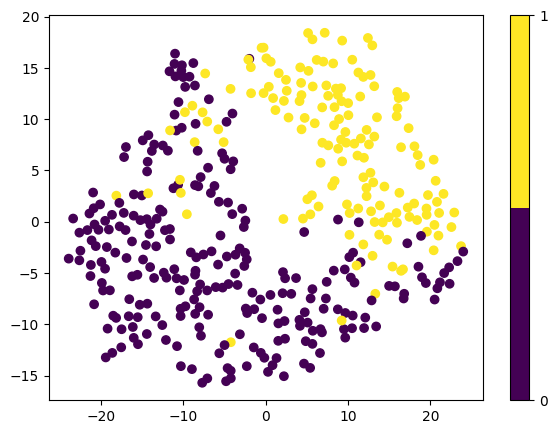

In [782]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.cm.get_cmap("viridis", 2))
plt.colorbar(ticks=[0, 1])
plt.show()

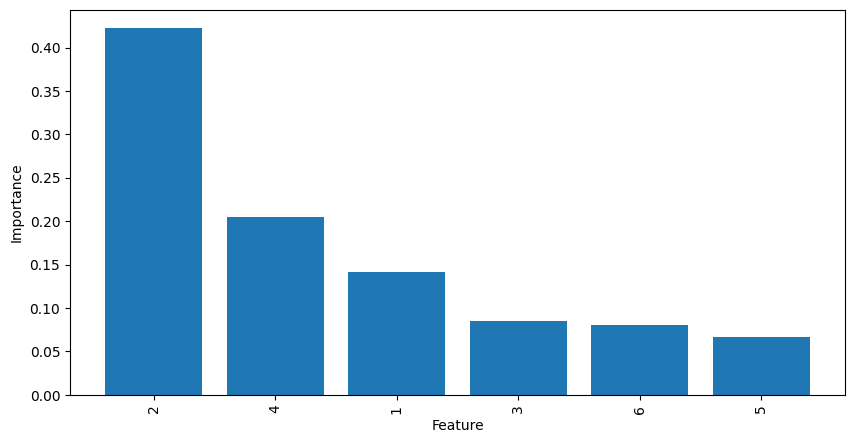

In [783]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices+1, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

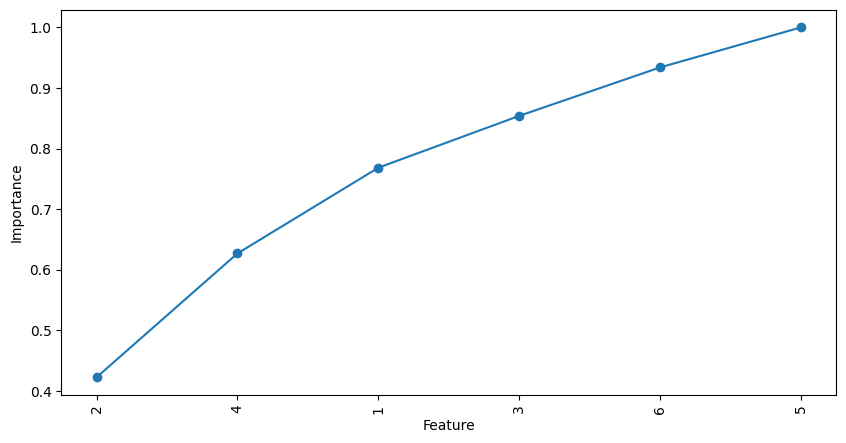

In [784]:
cumulative_importance = np.cumsum(importances[indices])

plt.figure(figsize=(10,5))
plt.plot(range(X_train.shape[1]), cumulative_importance, marker='o')
plt.xticks(range(X_train.shape[1]), indices+1, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [785]:
# definir los modelos
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
adab = AdaBoostClassifier(n_estimators=100, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier()
bag = BaggingClassifier(n_estimators=100, random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)
lr = LogisticRegression(random_state=42)
gradb = GradientBoostingClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
nb = GaussianNB()
sgd = SGDClassifier(random_state=42)

In [786]:
et_scores = cross_val_score(et, X_train, y_train, cv=3, scoring='accuracy')
adab_scores = cross_val_score(adab, X_train, y_train, cv=3, scoring='accuracy')
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring='accuracy')
knn_scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
bag_scores = cross_val_score(bag, X_train, y_train, cv=3, scoring='accuracy')
nn_scores = cross_val_score(nn, X_train, y_train, cv=3, scoring='accuracy')
lr_scores = cross_val_score(lr, X_train, y_train, cv=3, scoring='accuracy')
gradb_scores = cross_val_score(gradb, X_train, y_train, cv=3, scoring='accuracy')
dt_scores = cross_val_score(dt, X_train, y_train, cv=3, scoring='accuracy')
nb_scores = cross_val_score(nb, X_train, y_train, cv=3, scoring='accuracy')
sgd_scores = cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

In [787]:
# evaluar el rendimiento de los modelos en el conjunto de prueba
et_acc = et_scores.mean()
adab_acc = adab_scores.mean()
rf_acc = rf_scores.mean()
xgb_acc = xgb_scores.mean()
knn_acc = knn_scores.mean()
bag_acc = bag_scores.mean()
nn_acc = nn_scores.mean()
lr_acc = lr_scores.mean()
gradb_acc = gradb_scores.mean()
dt_acc = dt_scores.mean()
nb_acc = nb_scores.mean()
sgd_acc = sgd_scores.mean()

In [788]:
model_names = ['ET', 'Adab', 'RF', 'XgB', 'KNN', 'Bag', 'NN', 'LR', 'GradB', 'DT', 'NB', 'SGD']
accuracies = [et_acc, adab_acc, rf_acc, xgb_acc, knn_acc, bag_acc, nn_acc, lr_acc, gradb_acc, dt_acc, nb_acc, sgd_acc]

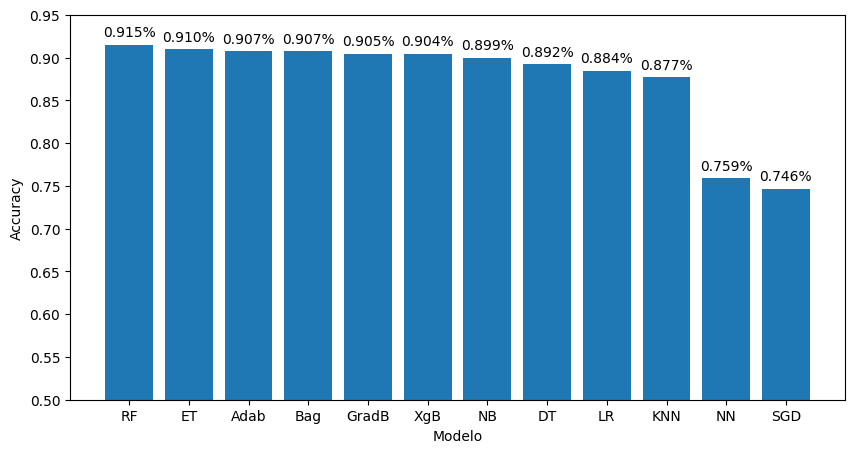

In [793]:
import operator

model_accuracies = list(zip(model_names, accuracies))
model_accuracies_sorted = sorted(model_accuracies, key=operator.itemgetter(1), reverse=True)

plt.figure(figsize=(10,5))
plt.bar([x[0] for x in model_accuracies_sorted], [x[1] for x in model_accuracies_sorted])
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.95])

for i, acc in enumerate([x[1] for x in model_accuracies_sorted]):
    plt.text(i, acc+0.01, f'{acc:.3f}%', ha='center')

plt.show()


In [824]:
model1 = AdaBoostClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(n_estimators=100, random_state=42)
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model4 = ExtraTreesClassifier(n_estimators=100, random_state=42)


preds_model1 = cross_val_predict(model1, X_train, y_train, cv=3, method='predict_proba')
preds_model2 = cross_val_predict(model2, X_train, y_train, cv=3, method='predict_proba')
preds_model3 = cross_val_predict(model3, X_train, y_train, cv=3, method='predict_proba')
preds_model4 = cross_val_predict(model4, X_train, y_train, cv=3, method='predict_proba')


# Tomar el promedio de las predicciones de cada modelo
preds_avg = (preds_model1 + preds_model2 + preds_model3 + preds_model4) / 4

# Convertir el promedio en una predicción final
final_preds = np.argmax(preds_avg, axis=1)

# Calcular la precisión del modelo ensamblado
accuracy = np.mean(final_preds == y_train)

print("Predicciones del modelo 1:", accuracies[2])
print("Precisión del modelo ensamblado:", accuracy)

Predicciones del modelo 1: 0.9145211513632566
Precisión del modelo ensamblado: 0.914572864321608


In [795]:
model1 = AdaBoostClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(n_estimators=100, random_state=42)
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model4 = ExtraTreesClassifier(n_estimators=100, random_state=42)

ensemble_model = VotingClassifier(estimators=[('AdaB', model1), ('Bag', model2), ('RF', model3), ('EX', model4)], voting='hard')

ensemble_model.fit(X_train, y_train)

accuracy = ensemble_model.score(X_test, y_test)

print("Precisión del modelo de ensamblado por votos:", accuracy)

Precisión del modelo de ensamblado por votos: 0.9707602339181286


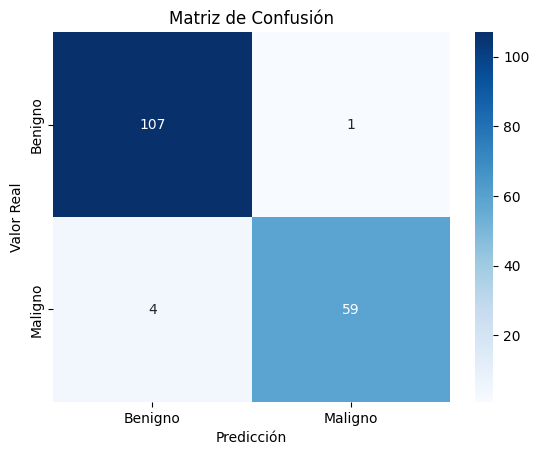

[[107   1]
 [  4  59]]


In [807]:
y_pred = ensemble_model.predict(X_test)

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear heatmap con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

print(cm)